In [1]:
# mostly pulled from hls4ml_3.ipynb and waveform_demo.ipynb
# last updated 2025-05-05 by mza
name = "mza_try6"
num_epochs = 10000
batch_size = 1000
hidden_nodes = [ 64 ]
hidden_node_type = "relu"
truths_to_use = [ 0 ] # t_peak, t_sigma, height, pedestal
use_pruning = False
prune_ratio = 0.1
train = True
synth_hls = True
integer_part = 1
input_quantization = 9
inner_quantization = 9
output_quantization = 10

In [2]:
import os, errno
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['PATH'] = os.environ['XILINX_VIVADO'] + '/bin:' + os.environ['PATH']
import numpy as np
seed = 0
np.random.seed(seed)
import matplotlib.pyplot as plt
try:
    os.mkdir(name)
except OSError as exception:
    if exception.errno != errno.EEXIST:
        raise

In [3]:
dataset1 = np.load('waveform_data_0.npy') # (10000, 104)
dataset2 = np.load('waveform_data_1.npy') # (10000, 104)
dataset = np.concatenate((dataset1, dataset2))
num_waveforms = len(dataset)
training_quantity = int(0.8 * num_waveforms)
num_truths = 4
time_samples = len(dataset[0]) - num_truths
print("num_waveforms: " + str(num_waveforms))
num_truths_to_use = len(truths_to_use)
print("num_truths_to_use: " + str(num_truths_to_use))
waveforms = dataset[:,num_truths:]
truths = dataset[:,:num_truths]
waveform_min = min([ min(waveforms[i]) for i in range(len(waveforms)) ])
waveform_max = max([ max(waveforms[i]) for i in range(len(waveforms)) ])
offset = waveform_min
gain = 1.0 / (waveform_max - waveform_min)
scaled_waveforms = np.array([ [ gain * (waveforms[j,i] - offset) for i in range(time_samples) ] for j in range(num_waveforms) ])
scaled_truths = np.array([ [ truths[j,0]/time_samples, truths[j,1]/time_samples, gain * (truths[j,2] - offset), gain * (truths[j,3] - offset) ] for j in range(num_waveforms) ])
train_data = scaled_waveforms[:training_quantity,:]
print("train_data.shape: " + str(train_data.shape))
train_truth = scaled_truths[:training_quantity,truths_to_use]
print("train_truth.shape: " + str(train_truth.shape))
test_data = scaled_waveforms[training_quantity:,:]
print("test_data.shape: " + str(test_data.shape))
test_truth = scaled_truths[training_quantity:,truths_to_use]
print("test_truth.shape: " + str(test_truth.shape))

num_waveforms: 20000
num_truths_to_use: 1
train_data.shape: (16000, 100)
train_truth.shape: (16000, 1)
test_data.shape: (4000, 100)
test_truth.shape: (4000, 1)


In [4]:
evt = 8
if 0:
    x = np.zeros(time_samples)
    for i in range(time_samples):
        x[i] = i/time_samples
    y = train_data[evt]
    plt.xlim(0, 1), plt.ylim(0, 1)
    plt.scatter(x, y)
    plt.plot([train_truth[evt][0], train_truth[evt][0]], [0.0, 1.0], color="green")
    plt.show()

In [5]:
print("time position of the peak: ", train_truth[evt][0]) # The 0th column: mean of the Gaussian peak

time position of the peak:  0.6038360595703125


In [6]:
import tensorflow as tf
tf.random.set_seed(seed)
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l1
from tensorflow.keras.layers import Activation
from tensorflow.keras import optimizers
from callbacks import all_callbacks
from qkeras.qlayers import QDense, QActivation
from qkeras.quantizers import quantized_bits, quantized_relu, quantized_sigmoid

In [7]:
input_quantizer = quantized_bits(input_quantization, integer_part, alpha=1)
inner_quantizer = quantized_bits(inner_quantization, integer_part, alpha=1)
output_quantizer = quantized_bits(output_quantization, integer_part, alpha=1)
output_quantization_string = 'ap_fixed<' + str(output_quantization) + ',' + str(integer_part) + '>'
if hidden_node_type=="relu":
    hidden_activations = [ quantized_relu(inner_quantization) for i in range(len(hidden_nodes)) ]
else:
    hidden_activations = [ quantized_sigmoid(inner_quantization) for i in range(len(hidden_nodes)) ]
hidden_names = [ hidden_node_type for i in range(len(hidden_nodes)) ]
model = Sequential()
model.add(QDense(time_samples, input_shape=(time_samples,), name='input_qdense', kernel_quantizer=input_quantizer, bias_quantizer=input_quantizer, kernel_initializer='glorot_uniform'))
model.add(QActivation(activation=quantized_sigmoid(input_quantization), name='input_sigmoid'))
for i in range(len(hidden_nodes)):
    model.add(QDense(hidden_nodes[i], name=hidden_names[i] + str(i) + "qdense", kernel_quantizer=inner_quantizer, bias_quantizer=inner_quantizer, kernel_initializer='glorot_uniform'))
    model.add(QActivation(activation=hidden_activations[i], name=hidden_names[i] + str(i) + "activation"))
model.add(QDense(num_truths_to_use, name='output_qdense', kernel_quantizer=output_quantizer, bias_quantizer=output_quantizer, kernel_initializer='glorot_uniform'))
if num_truths_to_use<2:
    model.add(Activation(activation='sigmoid', name='output_sigmoid'))
else:
    model.add(Activation(activation='softmax', name='output_softmax'))

In [8]:
if use_pruning:
    from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
    from tensorflow_model_optimization.sparsity.keras import strip_pruning
    # the first argument is the percentage of the weights that will be forced to be 0
    pruning_params = {"pruning_schedule": pruning_schedule.ConstantSparsity(prune_ratio, begin_step=2000, frequency=100)}
    model = prune.prune_low_magnitude(model, **pruning_params)

In [9]:
if train:
    #optimizer = optimizers.Adam(learning_rate=0.0001)
    optimizer = optimizers.SGD(learning_rate=0.1)
    #model.compile(optimizer=optimizer, loss=['categorical_crossentropy'], metrics=['accuracy'])
    model.compile(optimizer=optimizer, loss=['mse'])
    if use_pruning:
        callbacks = all_callbacks(stop_patience=1000, lr_factor=0.5, lr_patience=10, lr_epsilon=0.000001, lr_cooldown=2, lr_minimum=0.0000001, outputDir=name)
        callbacks.callbacks.append(pruning_callbacks.UpdatePruningStep())
        model.fit(train_data, train_truth, batch_size=batch_size, epochs=num_epochs, validation_split=0.25, shuffle=False, callbacks=callbacks.callbacks, verbose=0)
    else:
        model.fit(train_data, train_truth, batch_size=batch_size, epochs=num_epochs, validation_split=0.25, shuffle=False, verbose=0)
    #loss, acc = model.evaluate(test_data, test_truth, verbose=0)
    if use_pruning:
        model = strip_pruning(model)
    model.save(name + '/KERAS_check_best_model.keras')
else:
    from tensorflow.keras.models import load_model
    from qkeras.utils import _add_supported_quantized_objects
    co = {}
    _add_supported_quantized_objects(co)
    model = load_model(name + '/KERAS_check_best_model.keras', custom_objects=co) # TypeError: <qkeras.qlayers.QActivation object at 0x774300567100> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

/root/anaconda3/envs/hls4ml-tutorial/lib/python3.10/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


In [10]:
#print('test_acc: {:.3f}, test_loss: {:.3f}'.format(acc, loss))
train_prediction = model.predict(train_data)
test_prediction = model.predict(test_data)

125/125 [==============================] - 0s 584us/step


In [11]:
evt = 5
if 0:
    print(str(test_prediction[evt]) + " : " + str(test_truth[evt]))
    x = np.zeros(time_samples)
    for i in range(time_samples):
        x[i] = i/time_samples
    y = test_data[evt]
    plt.xlim(0, 1); plt.ylim(0, 1)
    plt.scatter(x, y, color="blue")
    plt.plot([test_prediction[evt,0], test_prediction[evt,0]], [0.0, 1.0], color="red")
    plt.plot([test_truth[evt,0], test_truth[evt,0]], [0.0, 1.0], color="green")
    plt.show()

In [12]:
import csv
with open(name + '/Input.dat', 'w') as f:
    csv.writer(f, delimiter=' ').writerows(test_data)
with open(name + '/Output.dat', 'w') as f:
    csv.writer(f, delimiter=' ').writerows(test_prediction)

In [13]:
import hls4ml, plotting
config = hls4ml.utils.config_from_keras_model(model, granularity='name')
config['LayerName']['output_sigmoid']['exp_table_t'] = output_quantization_string
config['LayerName']['output_sigmoid']['inv_table_t'] = output_quantization_string
config['LayerName']['output_sigmoid']['Precision']   = output_quantization_string
plotting.print_dict(config)
hls_model = hls4ml.converters.convert_from_keras_model(
    model, hls_config=config, output_dir=name + '/hls4ml_prj', part='xc7z020clg400-1',
    input_data_tb = name + "/Input.dat", output_data_tb = name + "/Output.dat", backend='Vitis', verbose=0
)

Interpreting Sequential
Topology:
Layer name: input_qdense_input, layer type: InputLayer, input shapes: [[None, 100]], output shape: [None, 100]
Layer name: input_qdense, layer type: QDense, input shapes: [[None, 100]], output shape: [None, 100]
Layer name: input_sigmoid, layer type: HardActivation, input shapes: [[None, 100]], output shape: [None, 100]
Layer name: relu0qdense, layer type: QDense, input shapes: [[None, 100]], output shape: [None, 64]
Layer name: relu0activation, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: output_qdense, layer type: QDense, input shapes: [[None, 64]], output shape: [None, 1]
Layer name: output_sigmoid, layer type: Activation, input shapes: [[None, 1]], output shape: [None, 1]
Model
  Precision
    default:         fixed<16,6>
  ReuseFactor:       1
  Strategy:          Latency
  BramFactor:        1000000000
  TraceOutput:       False
LayerName
  input_qdense_input
    Trace:           False
    Precision
   

/root/anaconda3/envs/hls4ml-tutorial/lib/python3.10/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


In [14]:
from IPython.display import Image
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=name + '/hls_model.png')
#Image(name + '/hls_model.png')

In [15]:
hls_model.compile()

/root/anaconda3/envs/hls4ml-tutorial/lib/python3.10/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


Writing HLS project
Done


In [16]:
hls_train_prediction = hls_model.predict(np.ascontiguousarray(train_data))
hls_test_prediction = hls_model.predict(np.ascontiguousarray(test_data))

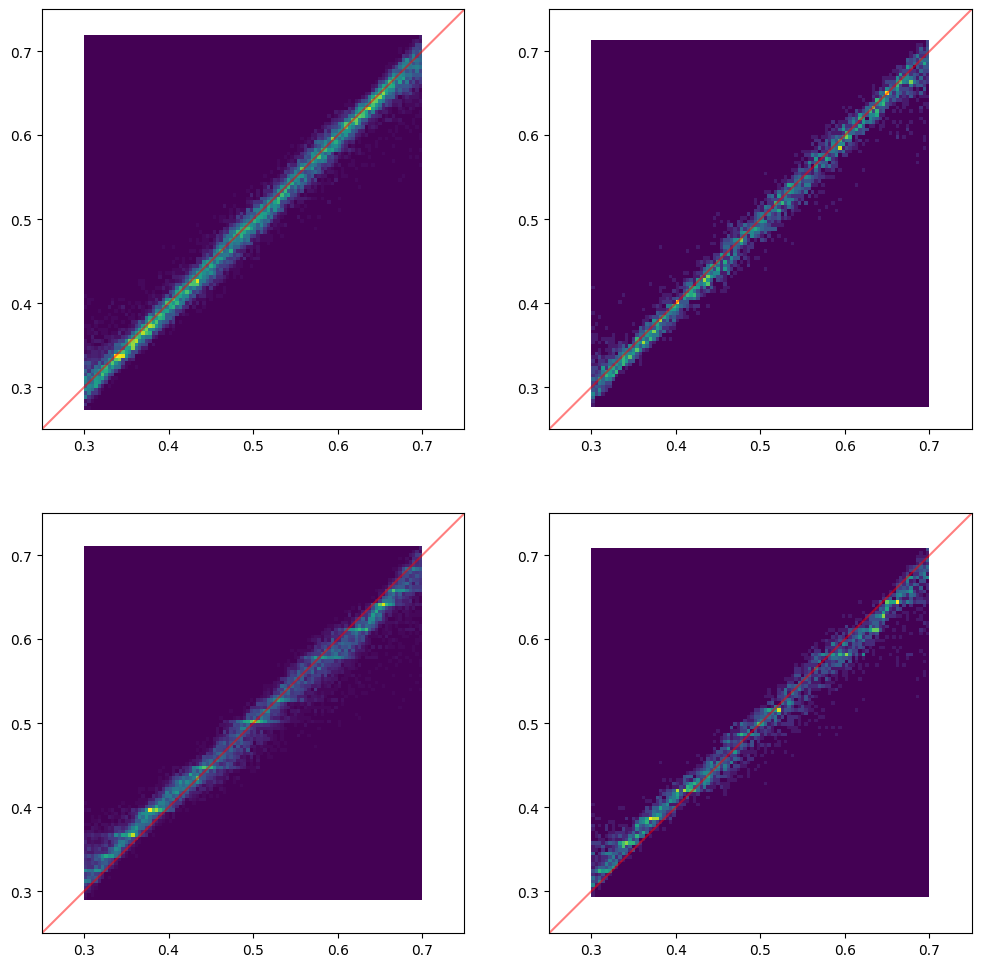

In [17]:
nbins = 100
a = 0.25; b = 0.75
for i in range(num_truths_to_use):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(12,12))
    ax1.hist2d(train_truth[:,i].ravel(), train_prediction[:,i].ravel(),     bins=nbins); ax1.plot([0.0, 1.0], [0.0, 1.0], color="red", alpha=0.5); ax1.set_xlim(a, b); ax1.set_ylim(a, b)
    ax2.hist2d(test_truth[:,i].ravel(),  test_prediction[:,i].ravel(),      bins=nbins); ax2.plot([0.0, 1.0], [0.0, 1.0], color="red", alpha=0.5); ax2.set_xlim(a, b); ax2.set_ylim(a, b)
    ax3.hist2d(train_truth[:,i].ravel(), hls_train_prediction[:,i].ravel(), bins=nbins); ax3.plot([0.0, 1.0], [0.0, 1.0], color="red", alpha=0.5); ax3.set_xlim(a, b); ax3.set_ylim(a, b)
    ax4.hist2d(test_truth[:,i].ravel(),  hls_test_prediction[:,i].ravel(),  bins=nbins); ax4.plot([0.0, 1.0], [0.0, 1.0], color="red", alpha=0.5); ax4.set_xlim(a, b); ax4.set_ylim(a, b)
    plt.show()
    fig.savefig(name + "/hist2d." + str(truths_to_use[i]) + ".png")

In [18]:
if synth_hls:
    hls_model.build(synth=True, csim=True, cosim=True)


****** Vitis HLS - High-Level Synthesis from C, C++ and OpenCL v2023.1 (64-bit)
  **** SW Build 3854077 on May  4 2023
  **** IP Build 3864474 on Sun May  7 20:36:21 MDT 2023
  **** SharedData Build 3865790 on Sun May 07 13:33:03 MDT 2023
    ** Copyright 1986-2022 Xilinx, Inc. All Rights Reserved.
    ** Copyright 2022-2023 Advanced Micro Devices, Inc. All Rights Reserved.

source /opt/Xilinx/Vitis_HLS/2023.1/scripts/vitis_hls/hls.tcl -notrace
INFO: [HLS 200-10] Running '/opt/Xilinx/Vitis_HLS/2023.1/bin/unwrapped/lnx64.o/vitis_hls'
INFO: [HLS 200-10] For user 'root' on host 'f1486668fc0d' (Linux_x86_64 version 6.11.0-21-generic) on Mon May 05 23:17:13 EDT 2025
INFO: [HLS 200-10] In directory '/root/build/phys476/final_project/waveform_dataset/mza_try6/hls4ml_prj'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-1510] Running: open_project myproject_prj 
INFO: [HLS 200-10] Opening project '/root/build/phys476/final_project/waveform_dataset/mza_try6/hls4ml_prj/myproject_prj'.
INFO: [

INFO: [HLS 214-131] Inlining function 'nnet::product::mult<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<9, 2, (ap_q_mode)5, (ap_o_mode)3, 0> >::product(ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<9, 2, (ap_q_mode)5, (ap_o_mode)3, 0>)' into 'void nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<33, 16, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>(ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>*, ap_fixed<33, 16, (ap_q_mode)5, (ap_o_mode)3, 0>*, config2::weight_t*, config2::bias_t*)' (firmware/nnet_utils/nnet_dense_latency.h:42:27)
INFO: [HLS 214-131] Inlining function 'nnet::DenseLatency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<33, 16, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>::dense(ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>*, ap_fixed<33, 16, (ap_q_mode)5, (ap_o_mode)3, 0>*, ap_fixed<9, 2, (ap_q_mode)5, (ap_o_mode)3, 0>*, ap_fixed<9, 2, (ap_q_mode)5, (ap_o_mode)3, 0>*)' into 'void nnet::dense<ap_fixed<16, 6, (ap_q_mode

INFO: [HLS 200-111] Finished Standard Transforms: CPU user time: 2.78 seconds. CPU system time: 0.05 seconds. Elapsed time: 2.83 seconds; current allocated memory: 1.201 GB.
INFO: [HLS 200-10] Checking synthesizability ...
INFO: [HLS 200-111] Finished Checking Synthesizability: CPU user time: 2.66 seconds. CPU system time: 0 seconds. Elapsed time: 2.66 seconds; current allocated memory: 1.201 GB.
INFO: [XFORM 203-401] Performing if-conversion on hyperblock from (firmware/nnet_utils/nnet_activation.h:98:10) to (firmware/nnet_utils/nnet_activation.h:123:1) in function 'nnet::sigmoid<ap_fixed<26, 9, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<10, 1, (ap_q_mode)5, (ap_o_mode)3, 0>, sigmoid_config10>'... converting 3 basic blocks.
INFO: [XFORM 203-401] Performing if-conversion on hyperblock from (firmware/nnet_utils/nnet_activation.h:43:31) to (firmware/nnet_utils/nnet_activation.h:50:1) in function 'nnet::relu<ap_fixed<26, 10, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_ufixed<9, 0, (ap_q_mode)4, (ap_

INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111] Finished Binding: CPU user time: 0.12 seconds. CPU system time: 0 seconds. Elapsed time: 0.12 seconds; current allocated memory: 3.966 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'dense_latency_ap_ufixed_9_0_4_0_0_ap_fixed_26_9_5_3_0_config8_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining function 'dense_latency<ap_ufixed<9, 0, 4, 0, 0>, ap_fixed<26, 9, 5, 3, 0>, config8>'.
INFO: [HLS 200-1470] Pipelining result : Target II = NA, Final II = 1, Depth = 7, function 'dense_latency<ap_ufixed<9, 0, 4, 0, 0>, a

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'sigmoid_ap_fixed_26_9_5_3_0_ap_fixed_10_1_5_3_0_sigmoid_config10_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SYN 201-210] Renamed object name 'sigmoid_ap_fixed_26_9_5_3_0_ap_fixed_10_1_5_3_0_sigmoid_config10_s_sigmoid_table_ROM_AUTO_1R' to 'sigmoid_ap_fixed_26_9_5_3_0_ap_fixed_10_1_5_3_0_sigmoid_config10_s_sigmoid_tabkb' due to the length limit 80
INFO: [HLS 200-1030] Apply Unified Pipeline Control on module 'sigmoid_ap_fixed_26_9_5_3_0_ap_fixed_10_1_5_3_0_sigmoid_config10_s' pipeline 'sigmoid<ap_fixed<26, 9, 5, 3, 0>, ap_fixed<10, 1, 5, 3, 0>, sigmoid_config10>' pipeline type 'function pipeline'
INFO: [RTGEN 206-100] Finished creating RTL model for 'sigmoid_ap_fixed_26_9_5_3_0_ap_fixed_10_1_5_3_0_sigmoid_config10_s'.
INFO: [RTMG 210-279] Implementing memory 'myproject_sigmoid_ap_fixed_26_9_5_3_0_ap_fixed

INFO: [VRFC 10-2263] Analyzing SystemVerilog file "/root/build/phys476/final_project/waveform_dataset/mza_try6/hls4ml_prj/myproject_prj/solution1/sim/verilog/myproject_mul_16s_5s_21_2_0.v" into library xil_defaultlib
INFO: [VRFC 10-311] analyzing module myproject_mul_16s_5s_21_2_0
INFO: [VRFC 10-2263] Analyzing SystemVerilog file "/root/build/phys476/final_project/waveform_dataset/mza_try6/hls4ml_prj/myproject_prj/solution1/sim/verilog/myproject_mul_16s_6ns_22_2_0.v" into library xil_defaultlib
INFO: [VRFC 10-311] analyzing module myproject_mul_16s_6ns_22_2_0
INFO: [VRFC 10-2263] Analyzing SystemVerilog file "/root/build/phys476/final_project/waveform_dataset/mza_try6/hls4ml_prj/myproject_prj/solution1/sim/verilog/myproject.autotb.v" into library xil_defaultlib
INFO: [VRFC 10-311] analyzing module apatb_myproject_top
INFO: [VRFC 10-2263] Analyzing SystemVerilog file "/root/build/phys476/final_project/waveform_dataset/mza_try6/hls4ml_prj/myproject_prj/solution1/sim/verilog/myproject_mul

// RTL Simulation : 1 / 4000 [97.50%] @ "323000"
// RTL Simulation : 2 / 4000 [97.50%] @ "328000"
// RTL Simulation : 3 / 4000 [97.50%] @ "333000"
// RTL Simulation : 4 / 4000 [97.50%] @ "338000"
// RTL Simulation : 5 / 4000 [97.50%] @ "343000"
// RTL Simulation : 6 / 4000 [97.50%] @ "348000"
// RTL Simulation : 7 / 4000 [97.50%] @ "353000"
// RTL Simulation : 8 / 4000 [97.50%] @ "358000"
// RTL Simulation : 9 / 4000 [97.50%] @ "363000"
// RTL Simulation : 10 / 4000 [97.50%] @ "368000"
// RTL Simulation : 11 / 4000 [97.50%] @ "373000"
// RTL Simulation : 12 / 4000 [97.50%] @ "378000"
// RTL Simulation : 13 / 4000 [97.50%] @ "383000"
// RTL Simulation : 14 / 4000 [97.50%] @ "388000"
// RTL Simulation : 15 / 4000 [97.50%] @ "393000"
// RTL Simulation : 16 / 4000 [97.50%] @ "398000"
// RTL Simulation : 17 / 4000 [97.50%] @ "403000"
// RTL Simulation : 18 / 4000 [97.50%] @ "408000"
// RTL Simulation : 19 / 4000 [97.50%] @ "413000"
// RTL Simulation : 20 / 4000 [97.50%] @ "418000"
// RTL Si

// RTL Simulation : 166 / 4000 [97.50%] @ "1148000"
// RTL Simulation : 167 / 4000 [97.50%] @ "1153000"
// RTL Simulation : 168 / 4000 [97.50%] @ "1158000"
// RTL Simulation : 169 / 4000 [97.50%] @ "1163000"
// RTL Simulation : 170 / 4000 [97.50%] @ "1168000"
// RTL Simulation : 171 / 4000 [97.50%] @ "1173000"
// RTL Simulation : 172 / 4000 [97.50%] @ "1178000"
// RTL Simulation : 173 / 4000 [97.50%] @ "1183000"
// RTL Simulation : 174 / 4000 [97.50%] @ "1188000"
// RTL Simulation : 175 / 4000 [97.50%] @ "1193000"
// RTL Simulation : 176 / 4000 [97.50%] @ "1198000"
// RTL Simulation : 177 / 4000 [97.50%] @ "1203000"
// RTL Simulation : 178 / 4000 [97.50%] @ "1208000"
// RTL Simulation : 179 / 4000 [97.50%] @ "1213000"
// RTL Simulation : 180 / 4000 [97.50%] @ "1218000"
// RTL Simulation : 181 / 4000 [97.50%] @ "1223000"
// RTL Simulation : 182 / 4000 [97.50%] @ "1228000"
// RTL Simulation : 183 / 4000 [97.50%] @ "1233000"
// RTL Simulation : 184 / 4000 [97.50%] @ "1238000"
// RTL Simul

// RTL Simulation : 329 / 4000 [97.50%] @ "1963000"
// RTL Simulation : 330 / 4000 [97.50%] @ "1968000"
// RTL Simulation : 331 / 4000 [97.50%] @ "1973000"
// RTL Simulation : 332 / 4000 [97.50%] @ "1978000"
// RTL Simulation : 333 / 4000 [97.50%] @ "1983000"
// RTL Simulation : 334 / 4000 [97.50%] @ "1988000"
// RTL Simulation : 335 / 4000 [97.50%] @ "1993000"
// RTL Simulation : 336 / 4000 [97.50%] @ "1998000"
// RTL Simulation : 337 / 4000 [97.50%] @ "2003000"
// RTL Simulation : 338 / 4000 [97.50%] @ "2008000"
// RTL Simulation : 339 / 4000 [97.50%] @ "2013000"
// RTL Simulation : 340 / 4000 [97.50%] @ "2018000"
// RTL Simulation : 341 / 4000 [97.50%] @ "2023000"
// RTL Simulation : 342 / 4000 [97.50%] @ "2028000"
// RTL Simulation : 343 / 4000 [97.50%] @ "2033000"
// RTL Simulation : 344 / 4000 [97.50%] @ "2038000"
// RTL Simulation : 345 / 4000 [97.50%] @ "2043000"
// RTL Simulation : 346 / 4000 [97.50%] @ "2048000"
// RTL Simulation : 347 / 4000 [97.50%] @ "2053000"
// RTL Simul

// RTL Simulation : 488 / 4000 [97.50%] @ "2758000"
// RTL Simulation : 489 / 4000 [97.50%] @ "2763000"
// RTL Simulation : 490 / 4000 [97.50%] @ "2768000"
// RTL Simulation : 491 / 4000 [97.50%] @ "2773000"
// RTL Simulation : 492 / 4000 [97.50%] @ "2778000"
// RTL Simulation : 493 / 4000 [97.50%] @ "2783000"
// RTL Simulation : 494 / 4000 [97.50%] @ "2788000"
// RTL Simulation : 495 / 4000 [97.50%] @ "2793000"
// RTL Simulation : 496 / 4000 [97.50%] @ "2798000"
// RTL Simulation : 497 / 4000 [97.50%] @ "2803000"
// RTL Simulation : 498 / 4000 [97.50%] @ "2808000"
// RTL Simulation : 499 / 4000 [97.50%] @ "2813000"
// RTL Simulation : 500 / 4000 [97.50%] @ "2818000"
// RTL Simulation : 501 / 4000 [97.50%] @ "2823000"
// RTL Simulation : 502 / 4000 [97.50%] @ "2828000"
// RTL Simulation : 503 / 4000 [97.50%] @ "2833000"
// RTL Simulation : 504 / 4000 [97.50%] @ "2838000"
// RTL Simulation : 505 / 4000 [97.50%] @ "2843000"
// RTL Simulation : 506 / 4000 [97.50%] @ "2848000"
// RTL Simul

// RTL Simulation : 654 / 4000 [97.50%] @ "3588000"
// RTL Simulation : 655 / 4000 [97.50%] @ "3593000"
// RTL Simulation : 656 / 4000 [97.50%] @ "3598000"
// RTL Simulation : 657 / 4000 [97.50%] @ "3603000"
// RTL Simulation : 658 / 4000 [97.50%] @ "3608000"
// RTL Simulation : 659 / 4000 [97.50%] @ "3613000"
// RTL Simulation : 660 / 4000 [97.50%] @ "3618000"
// RTL Simulation : 661 / 4000 [97.50%] @ "3623000"
// RTL Simulation : 662 / 4000 [97.50%] @ "3628000"
// RTL Simulation : 663 / 4000 [97.50%] @ "3633000"
// RTL Simulation : 664 / 4000 [97.50%] @ "3638000"
// RTL Simulation : 665 / 4000 [97.50%] @ "3643000"
// RTL Simulation : 666 / 4000 [97.50%] @ "3648000"
// RTL Simulation : 667 / 4000 [97.50%] @ "3653000"
// RTL Simulation : 668 / 4000 [97.50%] @ "3658000"
// RTL Simulation : 669 / 4000 [97.50%] @ "3663000"
// RTL Simulation : 670 / 4000 [97.50%] @ "3668000"
// RTL Simulation : 671 / 4000 [97.50%] @ "3673000"
// RTL Simulation : 672 / 4000 [97.50%] @ "3678000"
// RTL Simul

// RTL Simulation : 822 / 4000 [97.50%] @ "4428000"
// RTL Simulation : 823 / 4000 [97.50%] @ "4433000"
// RTL Simulation : 824 / 4000 [97.50%] @ "4438000"
// RTL Simulation : 825 / 4000 [97.50%] @ "4443000"
// RTL Simulation : 826 / 4000 [97.50%] @ "4448000"
// RTL Simulation : 827 / 4000 [97.50%] @ "4453000"
// RTL Simulation : 828 / 4000 [97.50%] @ "4458000"
// RTL Simulation : 829 / 4000 [97.50%] @ "4463000"
// RTL Simulation : 830 / 4000 [97.50%] @ "4468000"
// RTL Simulation : 831 / 4000 [97.50%] @ "4473000"
// RTL Simulation : 832 / 4000 [97.50%] @ "4478000"
// RTL Simulation : 833 / 4000 [97.50%] @ "4483000"
// RTL Simulation : 834 / 4000 [97.50%] @ "4488000"
// RTL Simulation : 835 / 4000 [97.50%] @ "4493000"
// RTL Simulation : 836 / 4000 [97.50%] @ "4498000"
// RTL Simulation : 837 / 4000 [97.50%] @ "4503000"
// RTL Simulation : 838 / 4000 [97.50%] @ "4508000"
// RTL Simulation : 839 / 4000 [97.50%] @ "4513000"
// RTL Simulation : 840 / 4000 [97.50%] @ "4518000"
// RTL Simul

// RTL Simulation : 989 / 4000 [97.50%] @ "5263000"
// RTL Simulation : 990 / 4000 [97.50%] @ "5268000"
// RTL Simulation : 991 / 4000 [97.50%] @ "5273000"
// RTL Simulation : 992 / 4000 [97.50%] @ "5278000"
// RTL Simulation : 993 / 4000 [97.50%] @ "5283000"
// RTL Simulation : 994 / 4000 [97.50%] @ "5288000"
// RTL Simulation : 995 / 4000 [97.50%] @ "5293000"
// RTL Simulation : 996 / 4000 [97.50%] @ "5298000"
// RTL Simulation : 997 / 4000 [97.50%] @ "5303000"
// RTL Simulation : 998 / 4000 [97.50%] @ "5308000"
// RTL Simulation : 999 / 4000 [97.50%] @ "5313000"
// RTL Simulation : 1000 / 4000 [97.50%] @ "5318000"
// RTL Simulation : 1001 / 4000 [97.50%] @ "5323000"
// RTL Simulation : 1002 / 4000 [97.50%] @ "5328000"
// RTL Simulation : 1003 / 4000 [97.50%] @ "5333000"
// RTL Simulation : 1004 / 4000 [97.50%] @ "5338000"
// RTL Simulation : 1005 / 4000 [97.50%] @ "5343000"
// RTL Simulation : 1006 / 4000 [97.50%] @ "5348000"
// RTL Simulation : 1007 / 4000 [97.50%] @ "5353000"
// R

// RTL Simulation : 1157 / 4000 [97.50%] @ "6103000"
// RTL Simulation : 1158 / 4000 [97.50%] @ "6108000"
// RTL Simulation : 1159 / 4000 [97.50%] @ "6113000"
// RTL Simulation : 1160 / 4000 [97.50%] @ "6118000"
// RTL Simulation : 1161 / 4000 [97.50%] @ "6123000"
// RTL Simulation : 1162 / 4000 [97.50%] @ "6128000"
// RTL Simulation : 1163 / 4000 [97.50%] @ "6133000"
// RTL Simulation : 1164 / 4000 [97.50%] @ "6138000"
// RTL Simulation : 1165 / 4000 [97.50%] @ "6143000"
// RTL Simulation : 1166 / 4000 [97.50%] @ "6148000"
// RTL Simulation : 1167 / 4000 [97.50%] @ "6153000"
// RTL Simulation : 1168 / 4000 [97.50%] @ "6158000"
// RTL Simulation : 1169 / 4000 [97.50%] @ "6163000"
// RTL Simulation : 1170 / 4000 [97.50%] @ "6168000"
// RTL Simulation : 1171 / 4000 [97.50%] @ "6173000"
// RTL Simulation : 1172 / 4000 [97.50%] @ "6178000"
// RTL Simulation : 1173 / 4000 [97.50%] @ "6183000"
// RTL Simulation : 1174 / 4000 [97.50%] @ "6188000"
// RTL Simulation : 1175 / 4000 [97.50%] @ "61

// RTL Simulation : 1325 / 4000 [97.50%] @ "6943000"
// RTL Simulation : 1326 / 4000 [97.50%] @ "6948000"
// RTL Simulation : 1327 / 4000 [97.50%] @ "6953000"
// RTL Simulation : 1328 / 4000 [97.50%] @ "6958000"
// RTL Simulation : 1329 / 4000 [97.50%] @ "6963000"
// RTL Simulation : 1330 / 4000 [97.50%] @ "6968000"
// RTL Simulation : 1331 / 4000 [97.50%] @ "6973000"
// RTL Simulation : 1332 / 4000 [97.50%] @ "6978000"
// RTL Simulation : 1333 / 4000 [97.50%] @ "6983000"
// RTL Simulation : 1334 / 4000 [97.50%] @ "6988000"
// RTL Simulation : 1335 / 4000 [97.50%] @ "6993000"
// RTL Simulation : 1336 / 4000 [97.50%] @ "6998000"
// RTL Simulation : 1337 / 4000 [97.50%] @ "7003000"
// RTL Simulation : 1338 / 4000 [97.50%] @ "7008000"
// RTL Simulation : 1339 / 4000 [97.50%] @ "7013000"
// RTL Simulation : 1340 / 4000 [97.50%] @ "7018000"
// RTL Simulation : 1341 / 4000 [97.50%] @ "7023000"
// RTL Simulation : 1342 / 4000 [97.50%] @ "7028000"
// RTL Simulation : 1343 / 4000 [97.50%] @ "70

// RTL Simulation : 1493 / 4000 [97.50%] @ "7783000"
// RTL Simulation : 1494 / 4000 [97.50%] @ "7788000"
// RTL Simulation : 1495 / 4000 [97.50%] @ "7793000"
// RTL Simulation : 1496 / 4000 [97.50%] @ "7798000"
// RTL Simulation : 1497 / 4000 [97.50%] @ "7803000"
// RTL Simulation : 1498 / 4000 [97.50%] @ "7808000"
// RTL Simulation : 1499 / 4000 [97.50%] @ "7813000"
// RTL Simulation : 1500 / 4000 [97.50%] @ "7818000"
// RTL Simulation : 1501 / 4000 [97.50%] @ "7823000"
// RTL Simulation : 1502 / 4000 [97.50%] @ "7828000"
// RTL Simulation : 1503 / 4000 [97.50%] @ "7833000"
// RTL Simulation : 1504 / 4000 [97.50%] @ "7838000"
// RTL Simulation : 1505 / 4000 [97.50%] @ "7843000"
// RTL Simulation : 1506 / 4000 [97.50%] @ "7848000"
// RTL Simulation : 1507 / 4000 [97.50%] @ "7853000"
// RTL Simulation : 1508 / 4000 [97.50%] @ "7858000"
// RTL Simulation : 1509 / 4000 [97.50%] @ "7863000"
// RTL Simulation : 1510 / 4000 [97.50%] @ "7868000"
// RTL Simulation : 1511 / 4000 [97.50%] @ "78

// RTL Simulation : 1661 / 4000 [97.50%] @ "8623000"
// RTL Simulation : 1662 / 4000 [97.50%] @ "8628000"
// RTL Simulation : 1663 / 4000 [97.50%] @ "8633000"
// RTL Simulation : 1664 / 4000 [97.50%] @ "8638000"
// RTL Simulation : 1665 / 4000 [97.50%] @ "8643000"
// RTL Simulation : 1666 / 4000 [97.50%] @ "8648000"
// RTL Simulation : 1667 / 4000 [97.50%] @ "8653000"
// RTL Simulation : 1668 / 4000 [97.50%] @ "8658000"
// RTL Simulation : 1669 / 4000 [97.50%] @ "8663000"
// RTL Simulation : 1670 / 4000 [97.50%] @ "8668000"
// RTL Simulation : 1671 / 4000 [97.50%] @ "8673000"
// RTL Simulation : 1672 / 4000 [97.50%] @ "8678000"
// RTL Simulation : 1673 / 4000 [97.50%] @ "8683000"
// RTL Simulation : 1674 / 4000 [97.50%] @ "8688000"
// RTL Simulation : 1675 / 4000 [97.50%] @ "8693000"
// RTL Simulation : 1676 / 4000 [97.50%] @ "8698000"
// RTL Simulation : 1677 / 4000 [97.50%] @ "8703000"
// RTL Simulation : 1678 / 4000 [97.50%] @ "8708000"
// RTL Simulation : 1679 / 4000 [97.50%] @ "87

// RTL Simulation : 1829 / 4000 [97.50%] @ "9463000"
// RTL Simulation : 1830 / 4000 [97.50%] @ "9468000"
// RTL Simulation : 1831 / 4000 [97.50%] @ "9473000"
// RTL Simulation : 1832 / 4000 [97.50%] @ "9478000"
// RTL Simulation : 1833 / 4000 [97.50%] @ "9483000"
// RTL Simulation : 1834 / 4000 [97.50%] @ "9488000"
// RTL Simulation : 1835 / 4000 [97.50%] @ "9493000"
// RTL Simulation : 1836 / 4000 [97.50%] @ "9498000"
// RTL Simulation : 1837 / 4000 [97.50%] @ "9503000"
// RTL Simulation : 1838 / 4000 [97.50%] @ "9508000"
// RTL Simulation : 1839 / 4000 [97.50%] @ "9513000"
// RTL Simulation : 1840 / 4000 [97.50%] @ "9518000"
// RTL Simulation : 1841 / 4000 [97.50%] @ "9523000"
// RTL Simulation : 1842 / 4000 [97.50%] @ "9528000"
// RTL Simulation : 1843 / 4000 [97.50%] @ "9533000"
// RTL Simulation : 1844 / 4000 [97.50%] @ "9538000"
// RTL Simulation : 1845 / 4000 [97.50%] @ "9543000"
// RTL Simulation : 1846 / 4000 [97.50%] @ "9548000"
// RTL Simulation : 1847 / 4000 [97.50%] @ "95

// RTL Simulation : 1983 / 4000 [97.50%] @ "10233000"
// RTL Simulation : 1984 / 4000 [97.50%] @ "10238000"
// RTL Simulation : 1985 / 4000 [97.50%] @ "10243000"
// RTL Simulation : 1986 / 4000 [97.50%] @ "10248000"
// RTL Simulation : 1987 / 4000 [97.50%] @ "10253000"
// RTL Simulation : 1988 / 4000 [97.50%] @ "10258000"
// RTL Simulation : 1989 / 4000 [97.50%] @ "10263000"
// RTL Simulation : 1990 / 4000 [97.50%] @ "10268000"
// RTL Simulation : 1991 / 4000 [97.50%] @ "10273000"
// RTL Simulation : 1992 / 4000 [97.50%] @ "10278000"
// RTL Simulation : 1993 / 4000 [97.50%] @ "10283000"
// RTL Simulation : 1994 / 4000 [97.50%] @ "10288000"
// RTL Simulation : 1995 / 4000 [97.50%] @ "10293000"
// RTL Simulation : 1996 / 4000 [97.50%] @ "10298000"
// RTL Simulation : 1997 / 4000 [97.50%] @ "10303000"
// RTL Simulation : 1998 / 4000 [97.50%] @ "10308000"
// RTL Simulation : 1999 / 4000 [97.50%] @ "10313000"
// RTL Simulation : 2000 / 4000 [97.50%] @ "10318000"
// RTL Simulation : 2001 / 4

// RTL Simulation : 2137 / 4000 [97.50%] @ "11003000"
// RTL Simulation : 2138 / 4000 [97.50%] @ "11008000"
// RTL Simulation : 2139 / 4000 [97.50%] @ "11013000"
// RTL Simulation : 2140 / 4000 [97.50%] @ "11018000"
// RTL Simulation : 2141 / 4000 [97.50%] @ "11023000"
// RTL Simulation : 2142 / 4000 [97.50%] @ "11028000"
// RTL Simulation : 2143 / 4000 [97.50%] @ "11033000"
// RTL Simulation : 2144 / 4000 [97.50%] @ "11038000"
// RTL Simulation : 2145 / 4000 [97.50%] @ "11043000"
// RTL Simulation : 2146 / 4000 [97.50%] @ "11048000"
// RTL Simulation : 2147 / 4000 [97.50%] @ "11053000"
// RTL Simulation : 2148 / 4000 [97.50%] @ "11058000"
// RTL Simulation : 2149 / 4000 [97.50%] @ "11063000"
// RTL Simulation : 2150 / 4000 [97.50%] @ "11068000"
// RTL Simulation : 2151 / 4000 [97.50%] @ "11073000"
// RTL Simulation : 2152 / 4000 [97.50%] @ "11078000"
// RTL Simulation : 2153 / 4000 [97.50%] @ "11083000"
// RTL Simulation : 2154 / 4000 [97.50%] @ "11088000"
// RTL Simulation : 2155 / 4

// RTL Simulation : 2291 / 4000 [97.50%] @ "11773000"
// RTL Simulation : 2292 / 4000 [97.50%] @ "11778000"
// RTL Simulation : 2293 / 4000 [97.50%] @ "11783000"
// RTL Simulation : 2294 / 4000 [97.50%] @ "11788000"
// RTL Simulation : 2295 / 4000 [97.50%] @ "11793000"
// RTL Simulation : 2296 / 4000 [97.50%] @ "11798000"
// RTL Simulation : 2297 / 4000 [97.50%] @ "11803000"
// RTL Simulation : 2298 / 4000 [97.50%] @ "11808000"
// RTL Simulation : 2299 / 4000 [97.50%] @ "11813000"
// RTL Simulation : 2300 / 4000 [97.50%] @ "11818000"
// RTL Simulation : 2301 / 4000 [97.50%] @ "11823000"
// RTL Simulation : 2302 / 4000 [97.50%] @ "11828000"
// RTL Simulation : 2303 / 4000 [97.50%] @ "11833000"
// RTL Simulation : 2304 / 4000 [97.50%] @ "11838000"
// RTL Simulation : 2305 / 4000 [97.50%] @ "11843000"
// RTL Simulation : 2306 / 4000 [97.50%] @ "11848000"
// RTL Simulation : 2307 / 4000 [97.50%] @ "11853000"
// RTL Simulation : 2308 / 4000 [97.50%] @ "11858000"
// RTL Simulation : 2309 / 4

// RTL Simulation : 2445 / 4000 [97.50%] @ "12543000"
// RTL Simulation : 2446 / 4000 [97.50%] @ "12548000"
// RTL Simulation : 2447 / 4000 [97.50%] @ "12553000"
// RTL Simulation : 2448 / 4000 [97.50%] @ "12558000"
// RTL Simulation : 2449 / 4000 [97.50%] @ "12563000"
// RTL Simulation : 2450 / 4000 [97.50%] @ "12568000"
// RTL Simulation : 2451 / 4000 [97.50%] @ "12573000"
// RTL Simulation : 2452 / 4000 [97.50%] @ "12578000"
// RTL Simulation : 2453 / 4000 [97.50%] @ "12583000"
// RTL Simulation : 2454 / 4000 [97.50%] @ "12588000"
// RTL Simulation : 2455 / 4000 [97.50%] @ "12593000"
// RTL Simulation : 2456 / 4000 [97.50%] @ "12598000"
// RTL Simulation : 2457 / 4000 [97.50%] @ "12603000"
// RTL Simulation : 2458 / 4000 [97.50%] @ "12608000"
// RTL Simulation : 2459 / 4000 [97.50%] @ "12613000"
// RTL Simulation : 2460 / 4000 [97.50%] @ "12618000"
// RTL Simulation : 2461 / 4000 [97.50%] @ "12623000"
// RTL Simulation : 2462 / 4000 [97.50%] @ "12628000"
// RTL Simulation : 2463 / 4

// RTL Simulation : 2599 / 4000 [97.50%] @ "13313000"
// RTL Simulation : 2600 / 4000 [97.50%] @ "13318000"
// RTL Simulation : 2601 / 4000 [97.50%] @ "13323000"
// RTL Simulation : 2602 / 4000 [97.50%] @ "13328000"
// RTL Simulation : 2603 / 4000 [97.50%] @ "13333000"
// RTL Simulation : 2604 / 4000 [97.50%] @ "13338000"
// RTL Simulation : 2605 / 4000 [97.50%] @ "13343000"
// RTL Simulation : 2606 / 4000 [97.50%] @ "13348000"
// RTL Simulation : 2607 / 4000 [97.50%] @ "13353000"
// RTL Simulation : 2608 / 4000 [97.50%] @ "13358000"
// RTL Simulation : 2609 / 4000 [97.50%] @ "13363000"
// RTL Simulation : 2610 / 4000 [97.50%] @ "13368000"
// RTL Simulation : 2611 / 4000 [97.50%] @ "13373000"
// RTL Simulation : 2612 / 4000 [97.50%] @ "13378000"
// RTL Simulation : 2613 / 4000 [97.50%] @ "13383000"
// RTL Simulation : 2614 / 4000 [97.50%] @ "13388000"
// RTL Simulation : 2615 / 4000 [97.50%] @ "13393000"
// RTL Simulation : 2616 / 4000 [97.50%] @ "13398000"
// RTL Simulation : 2617 / 4

// RTL Simulation : 2753 / 4000 [97.50%] @ "14083000"
// RTL Simulation : 2754 / 4000 [97.50%] @ "14088000"
// RTL Simulation : 2755 / 4000 [97.50%] @ "14093000"
// RTL Simulation : 2756 / 4000 [97.50%] @ "14098000"
// RTL Simulation : 2757 / 4000 [97.50%] @ "14103000"
// RTL Simulation : 2758 / 4000 [97.50%] @ "14108000"
// RTL Simulation : 2759 / 4000 [97.50%] @ "14113000"
// RTL Simulation : 2760 / 4000 [97.50%] @ "14118000"
// RTL Simulation : 2761 / 4000 [97.50%] @ "14123000"
// RTL Simulation : 2762 / 4000 [97.50%] @ "14128000"
// RTL Simulation : 2763 / 4000 [97.50%] @ "14133000"
// RTL Simulation : 2764 / 4000 [97.50%] @ "14138000"
// RTL Simulation : 2765 / 4000 [97.50%] @ "14143000"
// RTL Simulation : 2766 / 4000 [97.50%] @ "14148000"
// RTL Simulation : 2767 / 4000 [97.50%] @ "14153000"
// RTL Simulation : 2768 / 4000 [97.50%] @ "14158000"
// RTL Simulation : 2769 / 4000 [97.50%] @ "14163000"
// RTL Simulation : 2770 / 4000 [97.50%] @ "14168000"
// RTL Simulation : 2771 / 4

// RTL Simulation : 2907 / 4000 [97.50%] @ "14853000"
// RTL Simulation : 2908 / 4000 [97.50%] @ "14858000"
// RTL Simulation : 2909 / 4000 [97.50%] @ "14863000"
// RTL Simulation : 2910 / 4000 [97.50%] @ "14868000"
// RTL Simulation : 2911 / 4000 [97.50%] @ "14873000"
// RTL Simulation : 2912 / 4000 [97.50%] @ "14878000"
// RTL Simulation : 2913 / 4000 [97.50%] @ "14883000"
// RTL Simulation : 2914 / 4000 [97.50%] @ "14888000"
// RTL Simulation : 2915 / 4000 [97.50%] @ "14893000"
// RTL Simulation : 2916 / 4000 [97.50%] @ "14898000"
// RTL Simulation : 2917 / 4000 [97.50%] @ "14903000"
// RTL Simulation : 2918 / 4000 [97.50%] @ "14908000"
// RTL Simulation : 2919 / 4000 [97.50%] @ "14913000"
// RTL Simulation : 2920 / 4000 [97.50%] @ "14918000"
// RTL Simulation : 2921 / 4000 [97.50%] @ "14923000"
// RTL Simulation : 2922 / 4000 [97.50%] @ "14928000"
// RTL Simulation : 2923 / 4000 [97.50%] @ "14933000"
// RTL Simulation : 2924 / 4000 [97.50%] @ "14938000"
// RTL Simulation : 2925 / 4

// RTL Simulation : 3061 / 4000 [97.50%] @ "15623000"
// RTL Simulation : 3062 / 4000 [97.50%] @ "15628000"
// RTL Simulation : 3063 / 4000 [97.50%] @ "15633000"
// RTL Simulation : 3064 / 4000 [97.50%] @ "15638000"
// RTL Simulation : 3065 / 4000 [97.50%] @ "15643000"
// RTL Simulation : 3066 / 4000 [97.50%] @ "15648000"
// RTL Simulation : 3067 / 4000 [97.50%] @ "15653000"
// RTL Simulation : 3068 / 4000 [97.50%] @ "15658000"
// RTL Simulation : 3069 / 4000 [97.50%] @ "15663000"
// RTL Simulation : 3070 / 4000 [97.50%] @ "15668000"
// RTL Simulation : 3071 / 4000 [97.50%] @ "15673000"
// RTL Simulation : 3072 / 4000 [97.50%] @ "15678000"
// RTL Simulation : 3073 / 4000 [97.50%] @ "15683000"
// RTL Simulation : 3074 / 4000 [97.50%] @ "15688000"
// RTL Simulation : 3075 / 4000 [97.50%] @ "15693000"
// RTL Simulation : 3076 / 4000 [97.50%] @ "15698000"
// RTL Simulation : 3077 / 4000 [97.50%] @ "15703000"
// RTL Simulation : 3078 / 4000 [97.50%] @ "15708000"
// RTL Simulation : 3079 / 4

// RTL Simulation : 3215 / 4000 [97.50%] @ "16393000"
// RTL Simulation : 3216 / 4000 [97.50%] @ "16398000"
// RTL Simulation : 3217 / 4000 [97.50%] @ "16403000"
// RTL Simulation : 3218 / 4000 [97.50%] @ "16408000"
// RTL Simulation : 3219 / 4000 [97.50%] @ "16413000"
// RTL Simulation : 3220 / 4000 [97.50%] @ "16418000"
// RTL Simulation : 3221 / 4000 [97.50%] @ "16423000"
// RTL Simulation : 3222 / 4000 [97.50%] @ "16428000"
// RTL Simulation : 3223 / 4000 [97.50%] @ "16433000"
// RTL Simulation : 3224 / 4000 [97.50%] @ "16438000"
// RTL Simulation : 3225 / 4000 [97.50%] @ "16443000"
// RTL Simulation : 3226 / 4000 [97.50%] @ "16448000"
// RTL Simulation : 3227 / 4000 [97.50%] @ "16453000"
// RTL Simulation : 3228 / 4000 [97.50%] @ "16458000"
// RTL Simulation : 3229 / 4000 [97.50%] @ "16463000"
// RTL Simulation : 3230 / 4000 [97.50%] @ "16468000"
// RTL Simulation : 3231 / 4000 [97.50%] @ "16473000"
// RTL Simulation : 3232 / 4000 [97.50%] @ "16478000"
// RTL Simulation : 3233 / 4

// RTL Simulation : 3369 / 4000 [97.50%] @ "17163000"
// RTL Simulation : 3370 / 4000 [97.50%] @ "17168000"
// RTL Simulation : 3371 / 4000 [97.50%] @ "17173000"
// RTL Simulation : 3372 / 4000 [97.50%] @ "17178000"
// RTL Simulation : 3373 / 4000 [97.50%] @ "17183000"
// RTL Simulation : 3374 / 4000 [97.50%] @ "17188000"
// RTL Simulation : 3375 / 4000 [97.50%] @ "17193000"
// RTL Simulation : 3376 / 4000 [97.50%] @ "17198000"
// RTL Simulation : 3377 / 4000 [97.50%] @ "17203000"
// RTL Simulation : 3378 / 4000 [97.50%] @ "17208000"
// RTL Simulation : 3379 / 4000 [97.50%] @ "17213000"
// RTL Simulation : 3380 / 4000 [97.50%] @ "17218000"
// RTL Simulation : 3381 / 4000 [97.50%] @ "17223000"
// RTL Simulation : 3382 / 4000 [97.50%] @ "17228000"
// RTL Simulation : 3383 / 4000 [97.50%] @ "17233000"
// RTL Simulation : 3384 / 4000 [97.50%] @ "17238000"
// RTL Simulation : 3385 / 4000 [97.50%] @ "17243000"
// RTL Simulation : 3386 / 4000 [97.50%] @ "17248000"
// RTL Simulation : 3387 / 4

// RTL Simulation : 3523 / 4000 [97.50%] @ "17933000"
// RTL Simulation : 3524 / 4000 [97.50%] @ "17938000"
// RTL Simulation : 3525 / 4000 [97.50%] @ "17943000"
// RTL Simulation : 3526 / 4000 [97.50%] @ "17948000"
// RTL Simulation : 3527 / 4000 [97.50%] @ "17953000"
// RTL Simulation : 3528 / 4000 [97.50%] @ "17958000"
// RTL Simulation : 3529 / 4000 [97.50%] @ "17963000"
// RTL Simulation : 3530 / 4000 [97.50%] @ "17968000"
// RTL Simulation : 3531 / 4000 [97.50%] @ "17973000"
// RTL Simulation : 3532 / 4000 [97.50%] @ "17978000"
// RTL Simulation : 3533 / 4000 [97.50%] @ "17983000"
// RTL Simulation : 3534 / 4000 [97.50%] @ "17988000"
// RTL Simulation : 3535 / 4000 [97.50%] @ "17993000"
// RTL Simulation : 3536 / 4000 [97.50%] @ "17998000"
// RTL Simulation : 3537 / 4000 [97.50%] @ "18003000"
// RTL Simulation : 3538 / 4000 [97.50%] @ "18008000"
// RTL Simulation : 3539 / 4000 [97.50%] @ "18013000"
// RTL Simulation : 3540 / 4000 [97.50%] @ "18018000"
// RTL Simulation : 3541 / 4

// RTL Simulation : 3677 / 4000 [97.50%] @ "18703000"
// RTL Simulation : 3678 / 4000 [97.50%] @ "18708000"
// RTL Simulation : 3679 / 4000 [97.50%] @ "18713000"
// RTL Simulation : 3680 / 4000 [97.50%] @ "18718000"
// RTL Simulation : 3681 / 4000 [97.50%] @ "18723000"
// RTL Simulation : 3682 / 4000 [97.50%] @ "18728000"
// RTL Simulation : 3683 / 4000 [97.50%] @ "18733000"
// RTL Simulation : 3684 / 4000 [97.50%] @ "18738000"
// RTL Simulation : 3685 / 4000 [97.50%] @ "18743000"
// RTL Simulation : 3686 / 4000 [97.50%] @ "18748000"
// RTL Simulation : 3687 / 4000 [97.50%] @ "18753000"
// RTL Simulation : 3688 / 4000 [97.50%] @ "18758000"
// RTL Simulation : 3689 / 4000 [97.50%] @ "18763000"
// RTL Simulation : 3690 / 4000 [97.50%] @ "18768000"
// RTL Simulation : 3691 / 4000 [97.50%] @ "18773000"
// RTL Simulation : 3692 / 4000 [97.50%] @ "18778000"
// RTL Simulation : 3693 / 4000 [97.50%] @ "18783000"
// RTL Simulation : 3694 / 4000 [97.50%] @ "18788000"
// RTL Simulation : 3695 / 4

// RTL Simulation : 3831 / 4000 [97.50%] @ "19473000"
// RTL Simulation : 3832 / 4000 [97.50%] @ "19478000"
// RTL Simulation : 3833 / 4000 [97.50%] @ "19483000"
// RTL Simulation : 3834 / 4000 [97.50%] @ "19488000"
// RTL Simulation : 3835 / 4000 [97.50%] @ "19493000"
// RTL Simulation : 3836 / 4000 [97.50%] @ "19498000"
// RTL Simulation : 3837 / 4000 [97.50%] @ "19503000"
// RTL Simulation : 3838 / 4000 [97.50%] @ "19508000"
// RTL Simulation : 3839 / 4000 [97.50%] @ "19513000"
// RTL Simulation : 3840 / 4000 [97.50%] @ "19518000"
// RTL Simulation : 3841 / 4000 [97.50%] @ "19523000"
// RTL Simulation : 3842 / 4000 [97.50%] @ "19528000"
// RTL Simulation : 3843 / 4000 [97.50%] @ "19533000"
// RTL Simulation : 3844 / 4000 [97.50%] @ "19538000"
// RTL Simulation : 3845 / 4000 [97.50%] @ "19543000"
// RTL Simulation : 3846 / 4000 [97.50%] @ "19548000"
// RTL Simulation : 3847 / 4000 [97.50%] @ "19553000"
// RTL Simulation : 3848 / 4000 [97.50%] @ "19558000"
// RTL Simulation : 3849 / 4

INFO: [COSIM 212-316] Starting C post checking ...
Processing input 0
Predictions
0.522908 
Quantized predictions
0.521484 
INFO: Saved inference results to file: tb_data/rtl_cosim_results.log
INFO:
Report time       : Mon May  5 11:37:21 PM EDT 2025.
Solution          : solution1.
Simulation tool   : xsim.

+----------+----------+-----------------------------------------------+-----------------------------------------------+----------------------+
|          |          |             Latency(Clock Cycles)             |              Interval(Clock Cycles)           | Total Execution Time |
+   RTL    +  Status  +-----------------------------------------------+-----------------------------------------------+    (Clock Cycles)    +
|          |          |      min      |      avg      |      max      |      min      |      avg      |      max      |                      |
+----------+----------+-----------------------------------------------+-----------------------------------------------

In [19]:
if synth_hls:
    hls4ml.report.read_vivado_report(name + '/hls4ml_prj') # requires 2083 DSPs

Found 1 solution(s) in mza_try6/hls4ml_prj/myproject_prj.
Reports for solution "solution1":

C SIMULATION RESULT:
INFO: [SIM 2] *************** CSIM start ***************
INFO: [SIM 4] CSIM will launch GCC as the compiler.
   Compiling ../../../../myproject_test.cpp in debug mode
   Compiling ../../../../firmware/myproject.cpp in debug mode
   Generating csim.exe
Processing input 0
Predictions
0.522908 
Quantized predictions
0.521484 
INFO: Saved inference results to file: tb_data/csim_results.log
INFO: [SIM 1] CSim done with 0 errors.
INFO: [SIM 3] *************** CSIM finish ***************

SYNTHESIS REPORT:
== Vitis HLS Report for 'myproject'
* Date:           Mon May  5 23:35:25 2025

* Version:        2023.1 (Build 3854077 on May  4 2023)
* Project:        myproject_prj
* Solution:       solution1 (Vivado IP Flow Target)
* Product family: zynq
* Target device:  xc7z020-clg400-1


== Performance Estimates
+ Timing: 
    * Summary: 
    +--------+---------+----------+------------+
